# **Model Klasifikasi Gambar Bersih Kotor**

## **Import Required Library**

In [1]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 25.0
    Uninstalling packaging-25.0:
      Successfully uninstalled packaging-25.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 3.6.0 requires fsspec[http]<=2025.3.0,>=2023.1.0, but you have fsspec 2025.3.2 which is incompatible.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
bigframes 1.42.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.
plotnine 0.14.5 requires matplotlib>=3.8.0, but you have matplotlib 3.7.2 which is incompatible.
pandas-gbq 0.28.0 requires google-api-core<3.0.0dev,>=2.10.2, but you have google-api-core 1.34.1 which is incompatible

In [2]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import zipfile
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import LambdaCallback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV2, EfficientNetB0, EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2025-06-09 14:31:01.555106: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749479461.725695      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749479461.776222      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## **Data Preparation**

#### pengambilan dataset Bersih-Kotor

In [4]:
# Direktori awal untuk train, test, dan val
dir_ = "/kaggle/input/bersih-kotor-dataset/bersih_kotor_v5"

# Direktori baru untuk dataset gabungan
combined_dir = "/kaggle/working/dataset"

# Buat direktori baru untuk dataset gabungan
os.makedirs(combined_dir, exist_ok=True)

# Salin file dan folder dari train
for category in os.listdir(dir_):
    category_dir = os.path.join(dir_, category)
    if os.path.isdir(category_dir):
        shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

In [5]:
# Define source path
clean_dirty_path = "/kaggle/working/dataset"

# Melihat Jumlah data per kelas dan total data
counter = 0

for i in range(len(os.listdir(clean_dirty_path))):
  label = os.listdir(clean_dirty_path)[i]
  counter += len(os.listdir(f'{clean_dirty_path}/{label}'))
  print(f"{label} = {len(os.listdir(f'{clean_dirty_path}/{label}'))}")

print('-' * 15)
print(f"Total data pada dataset: {counter}")

dirty = 2700
clean = 2700
---------------
Total data pada dataset: 5400


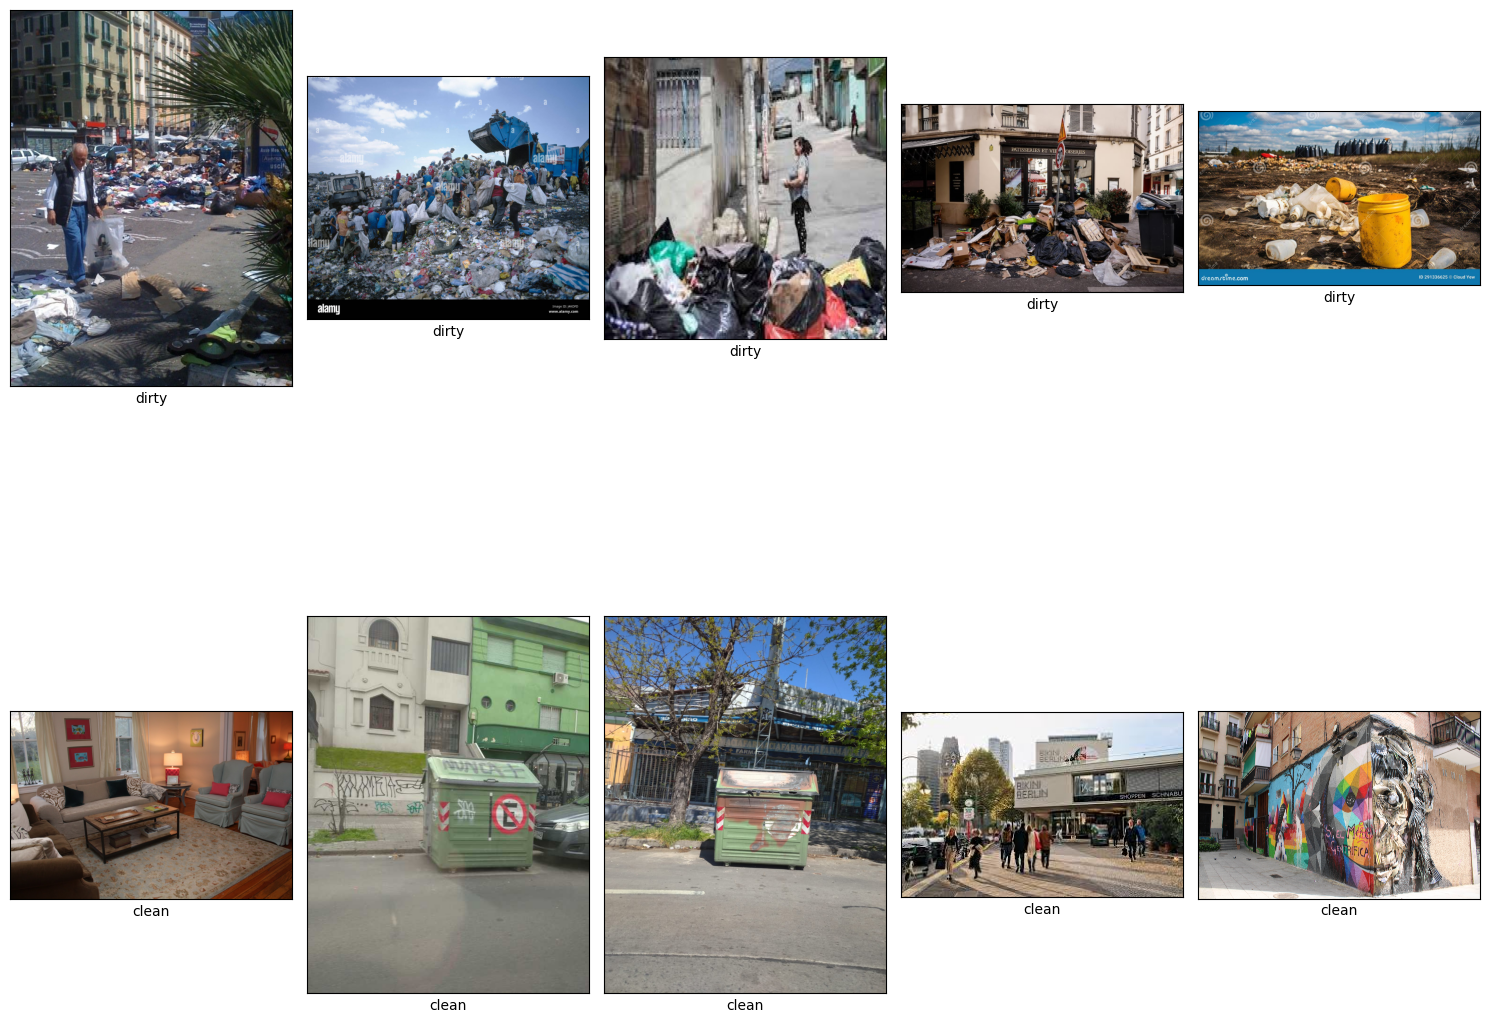

In [6]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
clean_dirty_image = {}

# Path sumber train
path = "/kaggle/working/"
path_sub = os.path.join(path, "dataset")

for class_name in os.listdir(path_sub):
    clean_dirty_image[class_name] = os.listdir(os.path.join(path_sub, class_name))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(clean_dirty_image.keys()), 5, figsize=(15, 15))
 
for i, class_name in enumerate(os.listdir(path_sub)):
    images = np.random.choice(clean_dirty_image[class_name], 5, replace=False)
 
    for j, image_name in enumerate(images):
        img_path = os.path.join(path_sub, class_name, image_name)
        img = Image.open(img_path)
        axs[i, j].imshow(img)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])
 
 
fig.tight_layout()
plt.show()

## **Data Preprocessing**

In [7]:
# Panggil variabel mypath yang menampung folder dataset gambar
# Path data akan dikumpulkan dalam dataframe untuk memudahkan reproduksi dalam split data
# Maksudnya, ketika notebook ini di run ulang, data untuk train dan val bisa tetap sama
mypath= "/kaggle/working/dataset"

file_name = []
labels = []
full_path = []

for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)


# Memasukan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapih
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

labels
clean    2700
dirty    2700
dtype: int64

### Split Dataset

In [8]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X = df['path']
y = df['labels']

# Split dataset menjadi train,test, val
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42)

# Komposisi 70, 15, 15
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})
df_val = pd.DataFrame({'path':X_val,'labels':y_val,'set':'val'})

In [10]:
print('train size', len(df_tr))
print('test size', len(df_te))
print('val size', len(df_val))

train size 3780
test size 810
val size 810


In [11]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te, df_val], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')


set    labels
test   clean      394
       dirty      416
train  clean     1910
       dirty     1870
val    clean      396
       dirty      414
dtype: int64 




In [12]:
# Memanggil dataset asli yang berisi keseluruhan data gambar yang sesuai dengan labelnya
datasource_path = "/kaggle/working/dataset"
# Membuat variabel Dataset, dimana nanti menampung data yang telah dilakukan pembagian data training dan testing
dataset_path = "/kaggle/working/Dataset-Final/"

In [13]:
for index, row in tq(df_all.iterrows()):
    # Deteksi filepath
    # file_path = row['path']
    # if os.path.exists(file_path) == False:
    #     file_path = os.path.join(datasource_path,row['labels'],row['image'].split('.')[0])
    file_path = row['path']
    if os.path.exists(file_path) == False:
        file_path = os.path.join(datasource_path, row['labels'], row['file_name'])

    # Buat direktori tujuan folder
    if os.path.exists(os.path.join(dataset_path,row['set'],row['labels'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['labels']))

    # Tentukan tujuan file
    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['labels'],destination_file_name)

    # Salin file dari sumber ke tujuan
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

0it [00:00, ?it/s]

## **Modeling**

In [14]:
TRAIN_DIR = "/kaggle/working/Dataset-Final/train/"
TEST_DIR = "/kaggle/working/Dataset-Final/test/"
VAL_DIR = "/kaggle/working/Dataset-Final/val/"

In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    zoom_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 3780 images belonging to 2 classes.
Found 810 images belonging to 2 classes.
Found 810 images belonging to 2 classes.


In [16]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # freeze layer awal

# Custom classifier di atas base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x) # Regularisasi tambahan
x = Dropout(0.3)(x)
preds = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=preds)

I0000 00:00:1749479524.327595      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749479524.328236      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 2,422,593 (9.24 MB)

 Trainable params: 164,353 (642.00 KB)

 Non-trainable params: 2,258,240 (8.61 MB)

In [18]:
# model.compile(optimizer=Adam(learning_rate=0.0005),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [19]:
def check_accuracy(epoch, logs):
    acc = logs.get('accuracy')
    val_acc = logs.get('val_accuracy')
    if acc > 0.95 and val_acc > 0.95:
        print(f"\nAccuracy dan Val Accuracy sudah lebih besar dari 95% di epoch {epoch+1}, training dihentikan!")
        model.stop_training = True

accuracy_threshold = LambdaCallback(on_epoch_end=check_accuracy)

In [20]:
checkpoint = ModelCheckpoint(
    'best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1
)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, verbose=1)

## **Train Model**

In [22]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator,
    callbacks=[accuracy_threshold, earlystop, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1749479537.560567      94 service.cc:148] XLA service 0x786620114a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749479537.570613      94 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1749479537.570641      94 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1749479538.673359      94 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/119 ━━━━━━━━━━━━━━━━━━━━ 29:14 15s/step - accuracy: 0.5625 - loss: 0.8271

I0000 00:00:1749479543.606075      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - accuracy: 0.8226 - loss: 0.3830
Epoch 1: val_accuracy improved from -inf to 0.89012, saving model to best_model.h5
119/119 ━━━━━━━━━━━━━━━━━━━━ 125s 934ms/step - accuracy: 0.8231 - loss: 0.3822 - val_accuracy: 0.8901 - val_loss: 0.2734
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9095 - loss: 0.2228
Epoch 2: val_accuracy improved from 0.89012 to 0.91235, saving model to best_model.h5
119/119 ━━━━━━━━━━━━━━━━━━━━ 101s 847ms/step - accuracy: 0.9095 - loss: 0.2227 - val_accuracy: 0.9123 - val_loss: 0.2278
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 681ms/step - accuracy: 0.9237 - loss: 0.1960
Epoch 3: val_accuracy improved from 0.91235 to 0.92222, saving model to best_model.h5
119/119 ━━━━━━━━━━━━━━━━━━━━ 100s 840ms/step - accuracy: 0.9237 - loss: 0.1961 - val_accuracy: 0.9222 - val_loss: 0.2328
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 687ms/step - accuracy: 0.9387 - loss: 0.1695
Epoch 4: val_accuracy did not improve fro

## **Evaluation & Visualization**

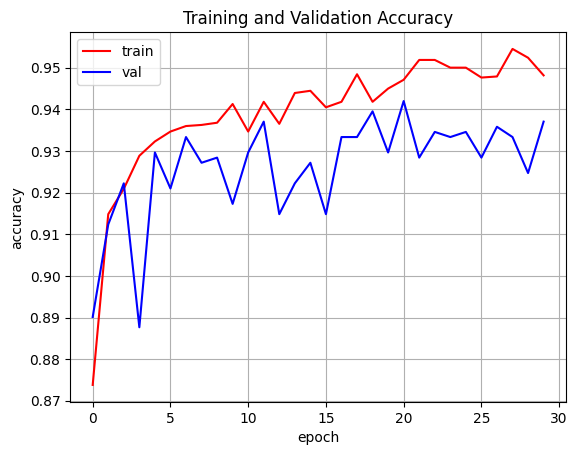

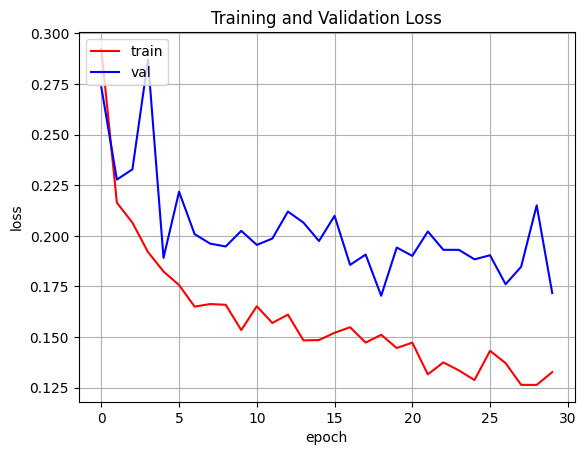

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

## **Finetune Ulang Model**

In [24]:
# Fine-tune: buka sebagian layer akhir
base_model.trainable = True

# Hanya fine-tune dari layer ke-100 ke atas (misal)
for layer in base_model.layers[:100]:
    layer.trainable = False

# Re-compile dengan learning rate lebih kecil untuk fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Fine-tune
history_finetune = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[accuracy_threshold, earlystop]
)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 138s 949ms/step - accuracy: 0.8781 - loss: 0.2975 - val_accuracy: 0.9111 - val_loss: 0.2611
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 100s 844ms/step - accuracy: 0.9147 - loss: 0.2162 - val_accuracy: 0.9198 - val_loss: 0.2814
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 100s 836ms/step - accuracy: 0.9294 - loss: 0.1887 - val_accuracy: 0.9309 - val_loss: 0.2353
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 101s 845ms/step - accuracy: 0.9370 - loss: 0.1547 - val_accuracy: 0.9259 - val_loss: 0.2477
Epoch 5/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 101s 843ms/step - accuracy: 0.9380 - loss: 0.1609 - val_accuracy: 0.9370 - val_loss: 0.2319
Epoch 6/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 99s 831ms/step - accuracy: 0.9460 - loss: 0.1438 - val_accuracy: 0.9296 - val_loss: 0.2114
Epoch 7/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 99s 829ms/step - accuracy: 0.9345 - loss: 0.1710 - val_accuracy: 0.9346 - val_loss: 0.2064
Epoch 8/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 100s 845ms/step - accuracy: 0.9423 - l

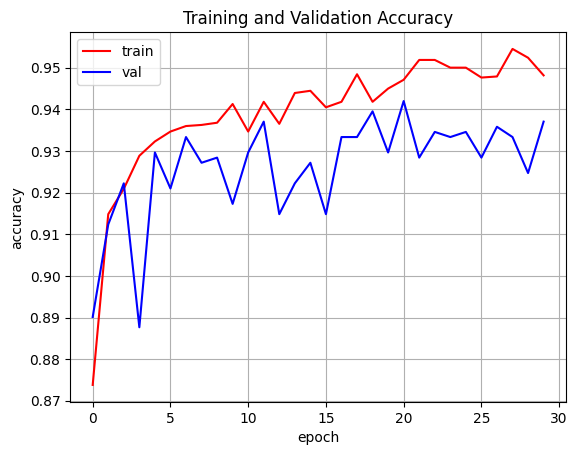

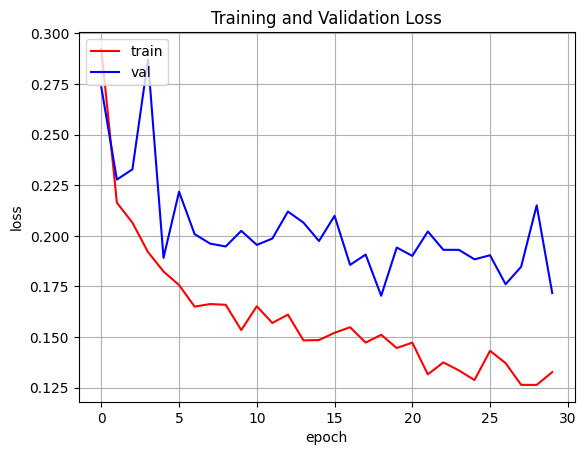

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.grid()
plt.show()

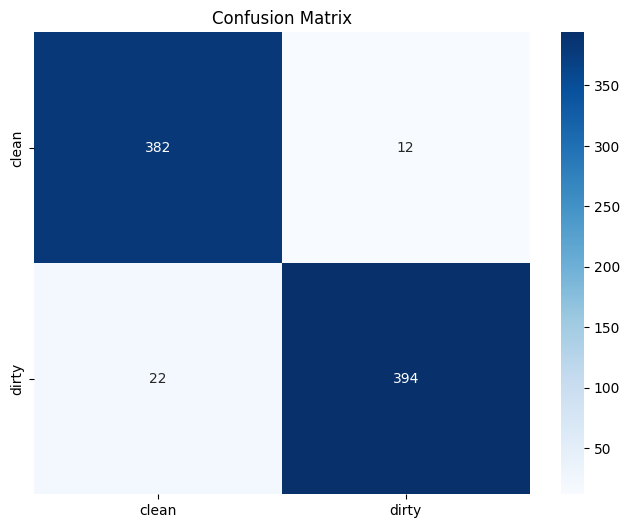


Classification Report:

              precision    recall  f1-score   support

       clean     0.9455    0.9695    0.9574       394
       dirty     0.9704    0.9471    0.9586       416

    accuracy                         0.9580       810
   macro avg     0.9580    0.9583    0.9580       810
weighted avg     0.9583    0.9580    0.9580       810



In [26]:
test_generator.reset()

preds = model.predict(test_generator, verbose=0)
preds_labels = (preds > 0.5).astype(int).flatten()

# Confusion Matrix
cm = pd.DataFrame(
    data=confusion_matrix(test_generator.classes, preds_labels),
    index=test_generator.class_indices.keys(),
    columns=test_generator.class_indices.keys()
)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:\n")
print(classification_report(
    y_true=test_generator.classes,
    y_pred=preds_labels,
    target_names=list(test_generator.class_indices.keys()),
    digits=4
))

## **Konversi Model**

In [27]:
saved_path = '/kaggle/working/saved_model'
tf.saved_model.save(model, saved_path)

In [28]:
# Path folder yang ingin di-zip
saved_path = '/kaggle/working/saved_model'

# Path output file zip
output_zip = '/kaggle/working/saved_model.zip'

# Membuat zip file
shutil.make_archive(base_name=output_zip.replace('.zip', ''), format='zip', root_dir=saved_path)

'/kaggle/working/saved_model.zip'

In [29]:
print(test_generator.class_indices)

{'clean': 0, 'dirty': 1}


In [30]:
# Simpan mapping class ke file
class_map = {0: "Bersih", 1: "Kotor"}
with open("class.txt", "w") as f:
    for k, v in class_map.items():
        f.write(f"{k}:{v}\n")

In [31]:
import os
import shutil

# Buat folder output
os.makedirs("model_exports", exist_ok=True)

# 1. Save ke .h5
model.save("model_exports/model.h5")

# 2. Save ke SavedModel
model.export("model_exports/saved_model")

# 3. Save sebagai JSON + Weights
with open("model_exports/model.json", "w") as json_file:
    json_file.write(model.to_json())
model.save_weights("model_exports/model.weights.h5")

# 4. Save format .keras
model.save("model_exports/model.keras")

# 5. Zip seluruh folder
shutil.make_archive("model_bundle", 'zip', "model_exports")


Saved artifact at 'model_exports/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132384056288144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132384056289296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132384056291216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132384056290832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132384056289680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132384056291408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132384056290064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132384056291984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132384056291600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132384056289488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  13238

'/kaggle/working/model_bundle.zip'

In [32]:
!tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model model_exports/saved_model/ model_exports/tfjs_model_from_saved/


2025-06-09 15:41:03.306948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749483663.342462    1028 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749483663.350117    1028 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
I0000 00:00:1749483672.074637    1028 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12794 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1749483672.075353    1028 gpu_device.cc:2022] Created device /job:localhost/replica:0

In [33]:
import shutil

# Buat zip dari seluruh folder model_exports
shutil.make_archive("model_bundle", 'zip', "model_exports")


'/kaggle/working/model_bundle.zip'

In [34]:
from IPython.display import FileLink

# Tampilkan link download langsung
FileLink("model_bundle.zip")


/kaggle/working/model_bundle.zip

In [35]:
import zipfile

# Bungkus file class.txt menjadi class.zip
with zipfile.ZipFile("class.zip", 'w') as zipf:
    zipf.write("class.txt")

# Tampilkan link download
from IPython.display import FileLink
FileLink("class.zip")


/kaggle/working/class.zip